In [1]:
import os, sys
import warnings
from tqdm import tqdm
import math
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from PIL import Image
from dataclasses import dataclass
from datasets import load_dataset, Dataset
import datasets
from typing import Any, Dict, List, Optional, Union


import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    GPT2Model, GPT2Tokenizer,
    
    CLIPVisionModel, CLIPProcessor,
    
    TrainingArguments, Trainer,
    
    logging, set_seed
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device.type == "cuda":
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 3090


In [3]:
# dataset = datasets.DatasetDict(
#     {
#     "train": Dataset.from_pandas(pd.read_feather("../CLIP-GPT2/data/clip-gpt2/train.feather")), 
#     "validation": Dataset.from_pandas(pd.read_feather("../CLIP-GPT2/data/clip-gpt2/validate.feather")), 
#     "test": Dataset.from_pandas(pd.read_feather("../CLIP-GPT2/data/clip-gpt2/test.feather"))
#     }
# )

In [4]:
dataset = load_dataset(
    "csv",
    data_files={
        "train": "../CLIP-GPT2/data/clip-gpt2/train.csv",
        "validate": "../CLIP-GPT2/data/clip-gpt2/validate.csv",
        "test": "../CLIP-GPT2/data/clip-gpt2/test.csv",
    }
)

reference_dataset = pd.read_feather("../CLIP-GPT2/data/clip-gpt2/reference.feather")

Using custom data configuration default-64915b5bddf97883
Found cached dataset csv (C:/Users/Keenan Samway/.cache/huggingface/datasets/csv/default-64915b5bddf97883/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'caption'],
        num_rows: 36409
    })
    validate: Dataset({
        features: ['image_id', 'caption'],
        num_rows: 2023
    })
    test: Dataset({
        features: ['image_id', 'caption'],
        num_rows: 2023
    })
})

In [6]:
def showExample(id=None):
    data = dataset["test"]
    
    if id is None:
        id = torch.randint(len(data['image_id']), size=(1,)).item()
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = Image.open(os.path.join("../datasets/AVA/images", data[id]['image_id']))
    print("Caption:", data[id]['caption'])
    print("Image ID:", data[id]['image_id'])
    display(img)
    

Caption: Children play badminton on the lawn .
Image ID: 508929192_670910fdd2.jpg


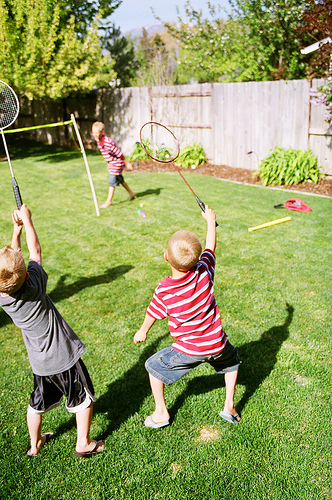

In [7]:
showExample()

In [8]:
@dataclass
class MyCollator:
    tokenizer: GPT2Tokenizer
    processor: CLIPProcessor
        
    def tokenize_text(self, texts):
        eos = self.tokenizer.eos_token
        texts = [eos + x + eos for x in texts]
        
        encoded_text = self.tokenizer(
            texts,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text["input_ids"].squeeze(),
            "attention_mask": encoded_text["attention_mask"].squeeze(),
        }
        
    def tokenize_labels(self, labels):
        eos = self.tokenizer.eos_token
        labels = [eos + x + eos for x in labels]
        
        encoded_labels = self.tokenizer(
            labels,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        )
        
        inv_bool_attention_mask = (1 - encoded_labels["attention_mask"]) > 0
        encoded_labels["input_ids"][inv_bool_attention_mask] = -100
        
        return {
            "labels": encoded_labels["input_ids"].squeeze(),
        }
        
    def process_image(self, images):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            processed_images = self.processor(
                images=[Image.open(os.path.join("..", "datasets/AVA/images", image_id)).convert('RGB') for image_id in images],
                return_tensors="pt",
                )
        return {
            "pixel_values": processed_images["pixel_values"].squeeze(),
        }
    
    def __call__(self, raw_batch_dict):        
        return {
            **self.tokenize_text(
                raw_batch_dict['caption']
                if isinstance(raw_batch_dict, dict) else
                [i['caption'] for i in raw_batch_dict]
            ),
            **self.process_image(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            **self.tokenize_labels(
                raw_batch_dict['caption']
                if isinstance(raw_batch_dict, dict) else
                [i['caption'] for i in raw_batch_dict]
            ),
        }

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [10]:

class MultimodalFusionModel(nn.Module):
    def __init__(self, text_model, image_model, vocab_size, embed_dim=512, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.text_model = text_model
        self.image_model = image_model
        
        # Pretrained transformers for encoding text and image
        self.text_encoder = GPT2Model.from_pretrained(text_model)
        for param in self.text_encoder.parameters():
            param.requires_grad = False
        
        self.image_encoder = CLIPVisionModel.from_pretrained(image_model)
        for param in self.image_encoder.parameters():
            param.requires_grad = False
        
        text_hidden_size = self.text_encoder.config.hidden_size
        #image_hidden_size = self.image_encoder.config.hidden_size
        
        # self.project_image = nn.Linear(image_hidden_size, text_hidden_size)
        
        self.positional_encoding = PositionalEncoding(text_hidden_size, dropout, max_len=1024)
        
        self.fusiontransformer = nn.Transformer(
            d_model=text_hidden_size,
            nhead=8,
            num_encoder_layers=6,
            num_decoder_layers=6,
            batch_first=True,
        )
        
        self.project_textencoder = nn.Sequential(
            nn.Linear(text_hidden_size, self.vocab_size, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        # Initialize this linear layer to GPT2's embedding layer
        self.project_textencoder[0].weight.data = self.text_encoder.wte.weight.data
        self.project_textencoder[0].weight.requires_grad = False
        
        self.project_fusionmodel = nn.Sequential(
            nn.Linear(text_hidden_size, self.vocab_size, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, 
                pixel_values : torch.FloatTensor,                       # (batch_size, 3, image_size, image_size)
                input_ids : Optional[torch.LongTensor]=None,            # (batch_size, sequence_length)
                attention_mask : Optional[torch.LongTensor]=None,       # (batch_size, sequence_length)
                labels : Optional[torch.LongTensor]=None):              # (batch_size, sequence_length)
        
        # encoded_text['last_hidden_state']: (batch_size, text_sequence_length, hidden_size=768)
        # encoded_images['last_hidden_state']: (batch_size, image_sequence_length=50, hidden_size=768)
        encoded_text = self.text_encoder(input_ids, attention_mask=attention_mask, return_dict=True)            
        encoded_images = self.image_encoder(pixel_values, return_dict=True)
        
        # if self.text_encoder.config.hidden_size != self.image_encoder.config.hidden_size:
        #     encoded_images["last_hidden_state"] = self.project_image(encoded_images["last_hidden_state"])
        
        tgt_mask = self.get_tgt_mask(encoded_text["last_hidden_state"].shape[1])
        tgt_key_padding_mask = (1 - attention_mask) > 0
                
        # fused_output: (batch_size, text_sequence_length, hidden_size=768)
        fused_output = self.fusiontransformer(
            self.positional_encoding(encoded_images["last_hidden_state"]),
            self.positional_encoding(encoded_text["last_hidden_state"]),
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
        )
        
        # projected_text: (batch_size, text_sequence_length, vocab_size)
        # projected_fusion: (batch_size, text_sequence_length, vocab_size)
        projected_text = self.project_textencoder(encoded_text["last_hidden_state"])
        projected_fusion = self.project_fusionmodel(fused_output)
        
        # logits: (batch_size, text_sequence_length, vocab_size)
        logits = projected_text + projected_fusion
        
        out = {"logits": logits}
        
        loss = None
        if labels is not None:                
            # Shift so that tokens < n predicts n
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            
            # Flatten tokens and calculate loss
            loss = self.criterion(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

            out["loss"] = loss
        
        return out

    # https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    def get_tgt_mask(self, size):
        mask = torch.tril(torch.ones(size, size) == 1)
        mask= mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf'))
        mask = mask.masked_fill(mask == 1, float(0.0))
        return mask.to(device)

In [11]:
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
def count_parameters(model):
    table = PrettyTable(['Modules', 'Parameters'])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [12]:
def createCollatorAndModel(text="gpt2", image="openai/clip-vit-base-patch32"):
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    processor = CLIPProcessor.from_pretrained(image)
    
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"
    
    mycollator = MyCollator(tokenizer=tokenizer, processor=processor)
    model = MultimodalFusionModel(text, image, tokenizer.vocab_size)
    
    return mycollator, model.to(device)

In [13]:
text_model_type = '../CLIP-GPT2/models/gpt2-small-AVA/checkpoint-20500'
text_model_type = 'gpt2'
image_model_type = 'openai/clip-vit-base-patch32'

In [14]:
logging.set_verbosity_error()
mycollator, model = createCollatorAndModel(text=text_model_type, image=image_model_type)

In [13]:
args = TrainingArguments(
    output_dir="../CLIP-GPT2/models/clip-gpt2/b32-small",
    seed=42,
    evaluation_strategy="steps",
    eval_steps=1000,
    eval_accumulation_steps=20,
    logging_strategy="steps",
    logging_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=3,
    metric_for_best_model="eval_loss",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    fp16=True,
    fp16_opt_level="O1",
    # warmup_ratio=0.01,
    # leraning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    dataloader_num_workers=0,
    load_best_model_at_end=True,
    disable_tqdm=False,
    dataloader_pin_memory=True,
)
set_seed(42)

In [14]:
class MyTrainer(Trainer):
    def _remove_unused_columns(self, dataset: "datasets.Dataset", description: Optional[str] = None):
        # Ignore _remove_unused_columns
        return dataset

In [15]:
trainer = MyTrainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validate'],
    data_collator=mycollator,
)

Using cuda_amp half precision backend


In [ ]:
if __name__ == "__main__":
    trainer.train()

# Inference

In [15]:
# https://colab.research.google.com/github/sachinruk/blog/blob/master/_notebooks/2021-12-28-vit-to-gpt2-encoder-decoder-model.ipynb#scrollTo=806799ae
def top_k_top_p_filtering(
    next_token_logits: torch.FloatTensor,
    top_k: Optional[float]=None, 
    top_p: Optional[float]=None,
    device: Union[str, torch.device]="cpu",
) -> torch.FloatTensor:
    if top_k is None:
        top_k = next_token_logits.shape[-1]
    if top_p is None:
        top_p = 1.0
        
    p, largest_p_idx = F.softmax(next_token_logits, dim=-1).topk(top_k, dim=-1)
    cumulative_p = p.cumsum(dim=-1)
    threshold_repeated = top_p + torch.zeros((len(p),1)).to(device)
    idx = torch.searchsorted(cumulative_p, threshold_repeated).clip(max=top_k-1).squeeze()
    cutoffs = cumulative_p[torch.arange(len(cumulative_p)), idx]
    censored_p = (cumulative_p <= cutoffs[:, None]) * p
    renormalized_p = censored_p / censored_p.sum(dim=-1, keepdims=True)
    
    final_p = torch.zeros_like(next_token_logits)
    row_idx = torch.arange(len(p)).unsqueeze(1).repeat(1,top_k).to(device)
    final_p[row_idx, largest_p_idx] = renormalized_p.to(final_p.dtype)

    return final_p

In [18]:
TOP_K = 50
TOP_P = 0.75

In [17]:
def generate_sentence_from_image(model, pixel_values, tokenizer, max_text_length: int):
    generated_so_far = torch.LongTensor([[tokenizer.bos_token_id]] * len(pixel_values)).to(device)
    
    with torch.no_grad():
        for _ in tqdm(range(max_text_length)):
            attention_mask = torch.ones_like(generated_so_far)
            
            outputs = model(
                input_ids=generated_so_far,
                attention_mask=attention_mask,
                pixel_values=pixel_values,
                labels=None,
            )
            
            next_token_logits = outputs['logits'][:, -1, :]
            filtered_p = top_k_top_p_filtering(next_token_logits, top_k=TOP_K, top_p=TOP_P, device=device)
            next_token = torch.multinomial(filtered_p, num_samples=1)
            # next_token = next_token_logits.argmax(dim=1).unsqueeze(-1)
            generated_so_far = torch.cat([generated_so_far, next_token], dim=1)

    return [tokenizer.decode(coded_sentence, skip_special_tokens=False) for coded_sentence in generated_so_far]

In [19]:
#text_model_type = '../CLIP-GPT2/models/gpt2-small-AVA/checkpoint-20500'
text_model_type = 'gpt2'
image_model_type = 'openai/clip-vit-base-patch32'

In [20]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [21]:
logging.set_verbosity_error()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = MultimodalFusionModel(text_model_type, image_model_type, tokenizer.vocab_size)
model.load_state_dict(torch.load('../CLIP-GPT2/models/clip-gpt2/b32-small-flickr/checkpoint-4552/pytorch_model.bin'))
model.to(device)
print("--loaded--")

--loaded--


In [22]:
start_idx = 0
end_idx = 20

In [23]:
sample = mycollator(dataset['test'][start_idx:end_idx])
pixel_values = sample['pixel_values'].to(device)
image_ids = dataset['test'][start_idx:end_idx]['image_id']

In [24]:
model.eval()
outputs = generate_sentence_from_image(model, pixel_values, tokenizer, max_text_length=50)

100%|██████████| 50/50 [00:05<00:00,  8.64it/s]


In [64]:
bleu = []
rouge = []
reference_list = []
candidate_list = []
for i in range(0, end_idx-start_idx):
    references = reference_dataset.loc[reference_dataset['image_id']==image_ids[i], 'captions'].iloc[0].tolist()
    candidate = outputs[i]
    b = sentence_bleu(references, candidate, weights=[0.25, 0.25, 0.25, 0.25])
    bleu.append(b)
    r = Rouge().get_scores(candidate, references[0])
    rouge.append(r)
    
    reference_list.append(references)
    candidate_list.append(candidate)

In [67]:
rouge[2]

[{'rouge-1': {'r': 0.17647058823529413,
   'p': 0.10714285714285714,
   'f': 0.13333332863209893},
  'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
  'rouge-l': {'r': 0.17647058823529413,
   'p': 0.10714285714285714,
   'f': 0.13333332863209893}}]

In [61]:
rouge[0]

[{'rouge-1': {'r': 0.17391304347826086,
   'p': 0.11764705882352941,
   'f': 0.14035087237919375},
  'rouge-2': {'r': 0.043478260869565216,
   'p': 0.024390243902439025,
   'f': 0.0312499953955085},
  'rouge-l': {'r': 0.17391304347826086,
   'p': 0.11764705882352941,
   'f': 0.14035087237919375}}]

In [60]:
average_bleu = sum(bleu)/len(bleu)
print(average_bleu)

0.5115172810281229


In [ ]:
x = 0
print(reference_list[x])
print("-------------------------------")
print(candidate_list[x])
print(bleu[x])

-------------------------
Prediction: <|endoftext|>A man stands to another woman while a woman wearing a brown toy's---fs.<|endoftext|><|endoftext|><|endoftext|><|endoftext|>shirt<|endoftext|><|endoftext|>slesashing<|endoftext|><|endoftext|><|endoftext|>saseds<|endoftext|>ss<|endoftext|><|endoftext|>shairedss<|endoftext|>irteds
Caption: Young man shows his tongue piercing while a woman stands next to him
Image ID: 279550225_d64d56158a.jpg


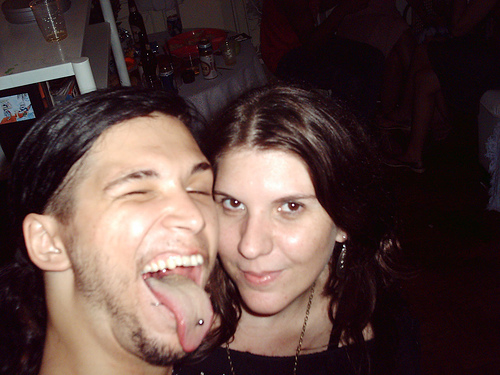

-------------------------
-------------------------
Prediction: <|endoftext|>Three people are posing with a crowd at a park.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>as<|endoftext|><|endoftext|>uddle<|endoftext|><|endoftext|><|endoftext|>aterss<|endoftext|>vesiers<|endoftext|>shirt in group in a crowd.<|endoftext|><|endoftext|><|endoftext|><|endoftext|>sierashing<|endoftext|>ate<|endoftext|>s<|endoftext|>ists
Caption: People with american flags gathered on the street .
Image ID: 3213622536_31da7f6682.jpg


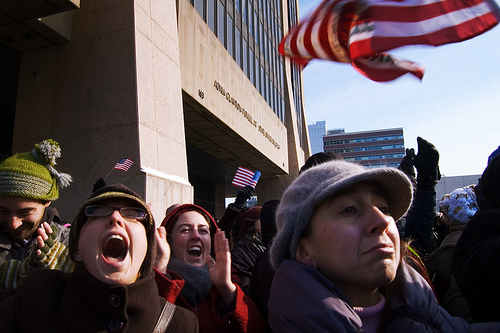

-------------------------
-------------------------
Prediction: <|endoftext|>A young child wearing green shirt and white shorts is jumping beside a small young large red shirt.<|endoftext|><|endoftext|><|endoftext|><|endoftext|>bee<|endoftext|><|endoftext|><|endoftext|><|endoftext|>ves<|endoftext|><|endoftext|><|endoftext|><|endoftext|>s<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>lings to its mouth.<|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Caption: a baby with a wristwatch is curious about something
Image ID: 2752043092_f48ebfeaa2.jpg


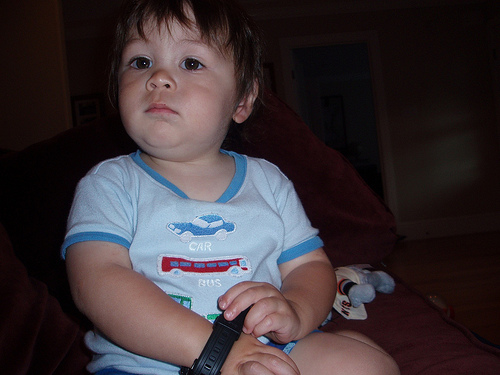

-------------------------
-------------------------
Prediction: <|endoftext|>Boy in blue mouth runs in the ground.<|endoftext|><|endoftext|><|endoftext|>ading<|endoftext|><|endoftext|><|endoftext|><|endoftext|>colored<|endoftext|>ading<|endoftext|>lesases<|endoftext|>lesases out.<|endoftext|>ler mouth tennis water in the water.<|endoftext|>-<|endoftext|>ashing a tennis ball.<|endoftext|>fer black mouth in
Caption: A brown dog shakes while standing in the water near a yellow ball .
Image ID: 3111402233_6285bcba7a.jpg


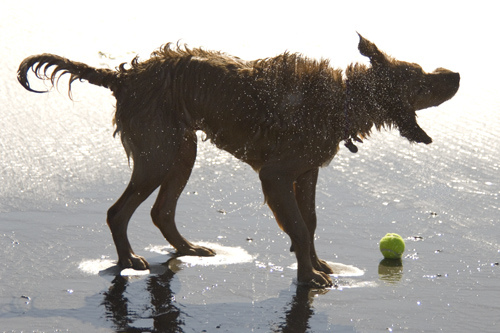

-------------------------
-------------------------
Prediction: <|endoftext|>Two wet dogs are chasing the snowy stick covered white hurdle.<|endoftext|>ases<|endoftext|>bee<|endoftext|>icycle<|endoftext|>ashing<|endoftext|>ading<|endoftext|>bee<|endoftext|>bee<|endoftext|>is through<|endoftext|>bee<|endoftext|>fer-bee<|endoftext|>ases<|endoftext|>bee snow.<|endoftext|>haired<|endoftext|>ier.<|endoftext|>is.<|endoftext|>
Caption: A dark dog jumps across the snow near the woods .
Image ID: 3322200641_c2e51ff37b.jpg


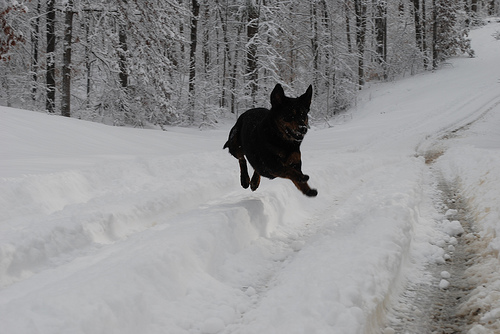

-------------------------
-------------------------
Prediction: <|endoftext|>A group of men in white teams are performing the game at the ice.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>bee<|endoftext|><|endoftext|><|endoftext|>is wearing red, a court while,.<|endoftext|>shirt.<|endoftext|><|endoftext|>ashes<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>ierbee<|endoftext|>bee game
Caption: A basketball game
Image ID: 3053743109_a2d780c0d2.jpg


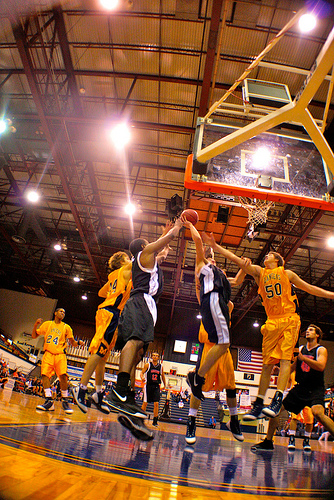

-------------------------
-------------------------
Prediction: <|endoftext|>A boy in a blue tshirt is jumping over a pool.<|endoftext|>ches<|endoftext|>ading<|endoftext|>ading<|endoftext|>ashes<|endoftext|>ashes<|endoftext|>sunks<|endoftext|>uddle<|endoftext|>ashes<|endoftext|> swimming.<|endoftext|>ashes<|endoftext|>unks<|endoftext|>aks jumps towards a boy.<|endoftext|>sbee<|endoftext|>ashing
Caption: A guy in navy blue and yellow shorts jumping into a pool .
Image ID: 3051998298_38da5746fa.jpg


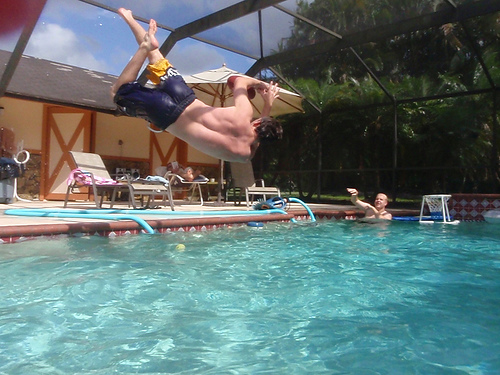

-------------------------
-------------------------
Prediction: <|endoftext|>A brown pcovered dog with a red sweater runs a toyed grass with one obstacle in the air.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>s<|endoftext|>s<|endoftext|><|endoftext|>ula<|endoftext|><|endoftext|>enced<|endoftext|><|endoftext|><|endoftext|>vesshirt<|endoftext|>ashing<|endoftext|><|endoftext|>covered
Caption: A small black and white dog on a leash wearing a shirt carrying a large stick .
Image ID: 2125454445_5c5c4bf906.jpg


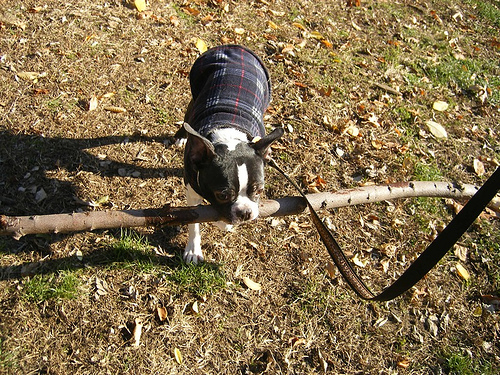

-------------------------
-------------------------
Prediction: <|endoftext|>two women standing together on front of a wall.<|endoftext|><|endoftext|><|endoftext|><|endoftext|>uddle<|endoftext|>icycles.<|endoftext|>ss<|endoftext|><|endoftext|>ired<|endoftext|>sicycle-ashes<|endoftext|>sired sitting holding a woman are a brown boy hanging to night.<|endoftext|>ival her smiling is
Caption: a few girls on a woooden pier eating ice cream cones
Image ID: 3677964239_6406ed096f.jpg


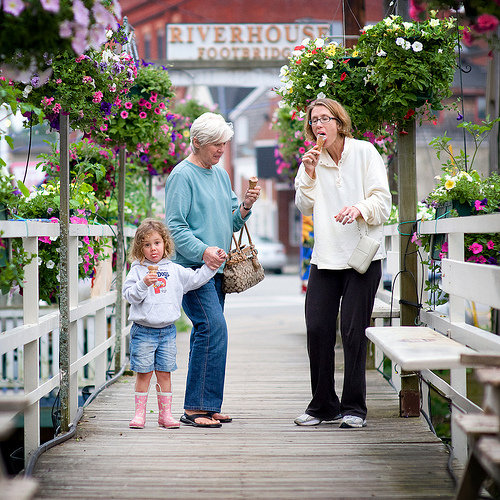

-------------------------
-------------------------
Prediction: <|endoftext|>A bicycleer on a racing bicycle in a race<|endoftext|>sikeristboardingairerclicyclesalscyclcoloreduddlesivaliersingalikeriker bikeer-seristboardingbasesrossikericycle-lerblal riderist
Caption: A group of cyclers race around a track .
Image ID: 3441145615_b4fcd9eea0.jpg


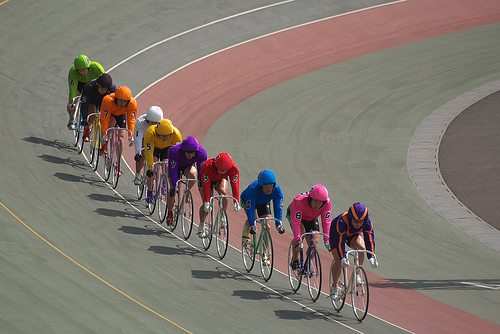

-------------------------
-------------------------
Prediction: <|endoftext|>White group is standing out together outside a street.<|endoftext|><|endoftext|><|endoftext|>ists<|endoftext|>ival<|endoftext|><|endoftext|>s<|endoftext|>is with the park<|endoftext|>saters.<|endoftext|>ides<|endoftext|>fides<|endoftext|>sss<|endoftext|>ogging a crowd.<|endoftext|>arate are people.<|endoftext|>ss
Caption: Group of young men posing and holding cans .
Image ID: 498444334_a680d318a1.jpg


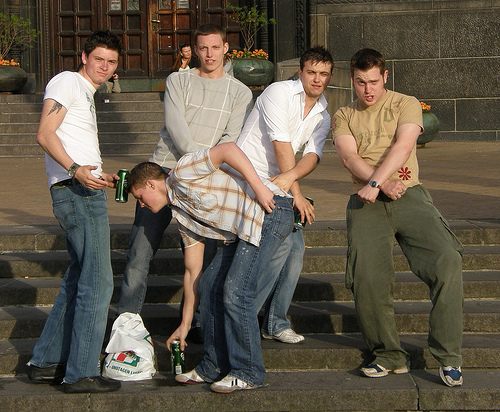

-------------------------
-------------------------
Prediction: <|endoftext|>Four men sitting in a building near the woods.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>as<|endoftext|><|endoftext|><|endoftext|>ssate<|endoftext|>ading<|endoftext|>ival-aters<|endoftext|>leseping<|endoftext|>sles-shirt.<|endoftext|>ashing at a large camera.<|endoftext|>uddless
Caption: Two people walk together on a cold day .
Image ID: 450596617_ed37ec0fe4.jpg


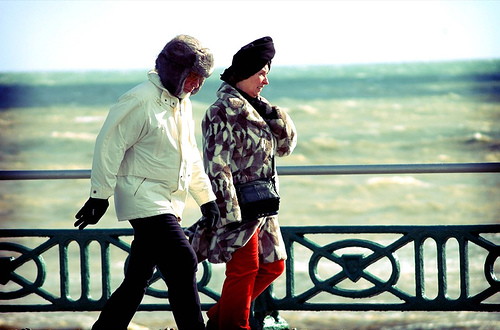

-------------------------
-------------------------
Prediction: <|endoftext|>A brown dog is carrying the toy in its mouth.<|endoftext|>is<|endoftext|><|endoftext|><|endoftext|>is<|endoftext|>is<|endoftext|>bee<|endoftext|><|endoftext|><|endoftext|><|endoftext|>bee<|endoftext|>bee<|endoftext|>ogs<|endoftext|>sbee<|endoftext|>uddle<|endoftext|><|endoftext|>ashes<|endoftext|>ases.<|endoftext|>unks<|endoftext|>bee<|endoftext|>air.<|endoftext|>enced
Caption: The black dog is running on the grass with a toy in its mouth .
Image ID: 2789350645_96a2535b4d.jpg


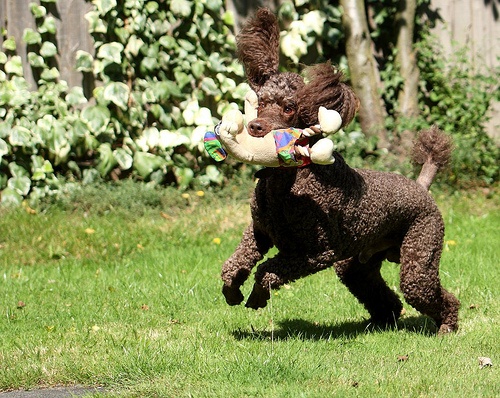

-------------------------
-------------------------
Prediction: <|endoftext|>O-ist children are sitting into a camera while holding some hands.<|endoftext|><|endoftext|><|endoftext|>covered<|endoftext|><|endoftext|><|endoftext|>s<|endoftext|><|endoftext|>s<|endoftext|>s<|endoftext|>iersoliness<|endoftext|>sss<|endoftext|>appingssashing<|endoftext|>ssshairedsarate with one
Caption: an Asian boy and an Asian girl are smiling in a crowd of people .
Image ID: 2339106348_2df90aa6a9.jpg


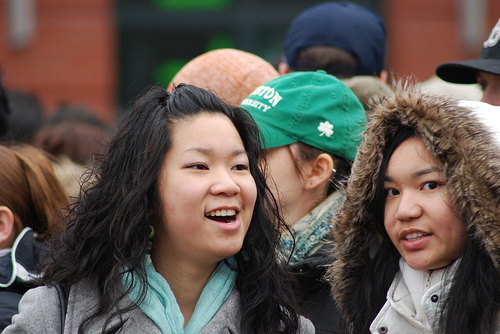

-------------------------
-------------------------
Prediction: <|endoftext|>The man is is at a trick-isboard in the air of mid of the air.<|endoftext|>ases<|endoftext|><|endoftext|>boarding<|endoftext|>ferboarding<|endoftext|>shirt in the ramp.<|endoftext|>lesboard<|endoftext|>lerblchesboard<|endoftext|>ate,.<|endoftext|>istboarding<|endoftext|>amp
Caption: A skateboarder on a ramp , doing a trick .
Image ID: 3351596152_bf283f03d1.jpg


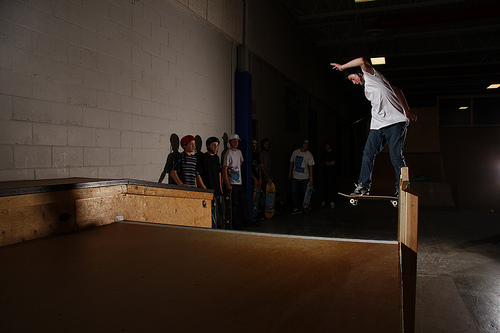

-------------------------
-------------------------
Prediction: <|endoftext|>A white brown dog runs through the water.<|endoftext|><|endoftext|><|endoftext|>ashing<|endoftext|><|endoftext|><|endoftext|>ashed<|endoftext|>s<|endoftext|><|endoftext|>ashed<|endoftext|>ing<|endoftext|>ashing<|endoftext|>colored<|endoftext|>sashing<|endoftext|>ler<|endoftext|>ashing<|endoftext|>ashing<|endoftext|>ier<|endoftext|>lers<|endoftext|>s<|endoftext|>elss<|endoftext|>ing<|endoftext|>
Caption: A small black and white dog carries a stick while swimming .
Image ID: 3146232740_df3da0163b.jpg


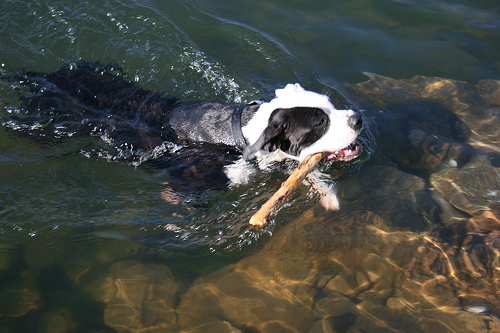

-------------------------
-------------------------
Prediction: <|endoftext|>a brown puppy runs across the air.<|endoftext|><|endoftext|>is another yards yard.<|endoftext|><|endoftext|>uzzashing<|endoftext|>ashes<|endoftext|>uddle<|endoftext|>ases her area<|endoftext|>bee through mid area.<|endoftext|>ogging.<|endoftext|>ips trees.<|endoftext|><|endoftext|>isting.<|endoftext|><|endoftext|><|endoftext|>uddle
Caption: Black dog in a bandanna runs down a dirt road .
Image ID: 3523920786_0eb63993fd.jpg


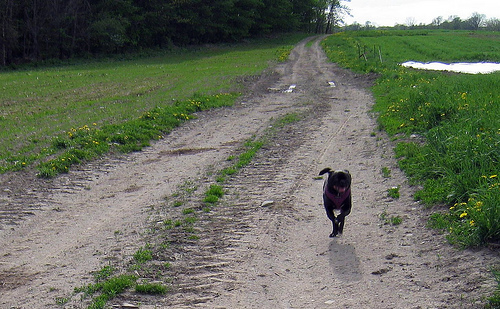

-------------------------
-------------------------
Prediction: <|endoftext|>A dog jumps on a yellow Frases ball.<|endoftext|><|endoftext|>s<|endoftext|><|endoftext|>is<|endoftext|>bee<|endoftext|>is<|endoftext|>ches<|endoftext|>enced<|endoftext|><|endoftext|>is.<|endoftext|>bee<|endoftext|>bee<|endoftext|>air.<|endoftext|>bee<|endoftext|>ing<|endoftext|>els road<|endoftext|>bee<|endoftext|>s<|endoftext|>ed<|endoftext|>ases
Caption: A Frisbee casts a shadow on the dog .
Image ID: 485054073_fef8b80b4b.jpg


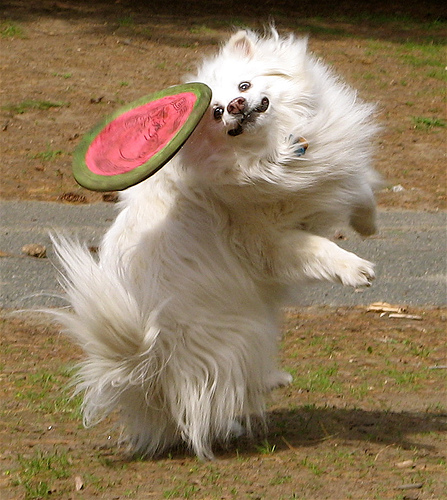

-------------------------
-------------------------
Prediction: <|endoftext|>A man holding a black building and looking a dog and red hat walks under him.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>lesipsite<|endoftext|><|endoftext|>ases<|endoftext|>vesicycle<|endoftext|>ogging<|endoftext|>-ases<|endoftext|>vesis<|endoftext|>shirt
Caption: A man sits in front of an ATM machine while another man uses the machine .
Image ID: 948196883_e190a483b1.jpg


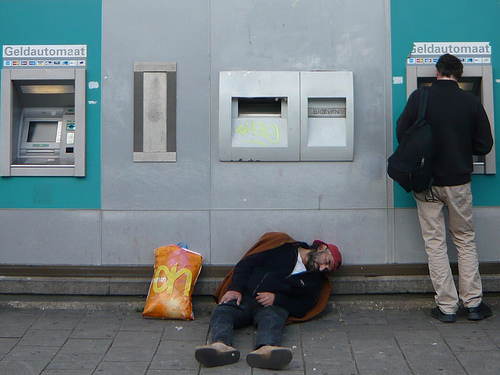

-------------------------
-------------------------
Prediction: <|endoftext|>A child jumps on a colorful fence with hands on a horse.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>ampair<|endoftext|>s<|endoftext|>ampairbee<|endoftext|>uddle<|endoftext|>ases<|endoftext|>uddle<|endoftext|>lingula<|endoftext|>ampenced<|endoftext|>beeses<|endoftext|>
Caption: Little boy doing a flying kick in a lited room with shadows .
Image ID: 664341930_bd5c8b60ea.jpg


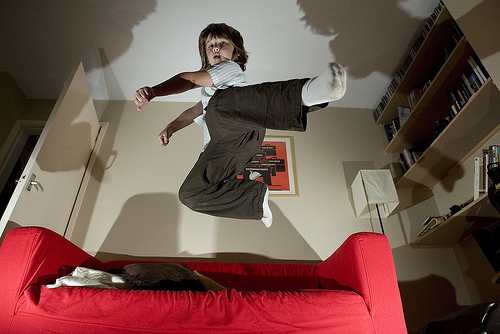

-------------------------


In [25]:
for i in range(0, end_idx-start_idx):
    print("-------------------------")
    print("Prediction:", outputs[i])
    #print("BLEU-4: ", bleu[i])
    showExample(i+start_idx)
    print("-------------------------")
    if i > 20: break